In [1]:
%load_ext bigquery_magics

# "Will it snow tomorrow?" - The time traveler asked
The following dataset contains climate information from over 9000 stations accross the world. The overall goal of these subtasks will be to predict whether it will snow tomorrow 20 years ago. So if today is 1 April 2025 then the weather we want to forecast is for the 2 April 2005. You are supposed to solve the tasks using Big Query, which can be used in the Jupyter Notebook like it is shown in the following cell. For further information and how to use BigQuery in Jupyter Notebook refer to the Google Docs. 

The goal of this test is to test your coding knowledge in Python, BigQuery and Pandas as well as your understanding of Data Science. If you get stuck in the first part, you can use the replacement data provided in the second part.

In [3]:
%%bigquery
SELECT
*,
FROM `bigquery-public-data.samples.gsod`
LIMIT 20 


Query is running:   0%|          |

Downloading:   0%|          |

,station_number,wban_number,year,month,day,mean_temp,num_mean_temp_samples,mean_dew_point,num_mean_dew_point_samples,mean_sealevel_pressure,...,min_temperature,min_temperature_explicit,total_precipitation,snow_depth,fog,rain,snow,hail,thunder,tornado
0,30050,99999,1929,12,31,38.700001,4,34.000000,4,996.900024,...,NaN,<NA>,0.00,NaN,False,False,False,False,False,False
1,33790,99999,1929,10,7,48.200001,4,41.299999,4,1003.000000,...,NaN,<NA>,0.00,NaN,False,False,False,False,False,False
2,37770,99999,1929,10,7,51.299999,4,43.200001,4,1006.700012,...,NaN,<NA>,0.00,NaN,False,False,False,False,False,False
3,38640,99999,1929,11,15,39.500000,4,34.700001,4,1002.400024,...,NaN,<NA>,NaN,NaN,True,True,True,True,True,True
4,36010,99999,1929,11,13,44.000000,4,40.000000,4,999.200012,...,NaN,<NA>,0.00,NaN,False,False,False,False,False,False
5,38940,99999,1929,10,5,56.000000,4,49.000000,4,1005.400024,...,NaN,<NA>,0.00,NaN,False,False,False,False,False,False
6,33110,99999,1929,11,13,43.799999,4,37.500000,4,998.400024,...,NaN,<NA>,0.00,NaN,False,False,False,False,False,False
7,37770,99999,1929,10,12,57.200001,4,53.200001,4,1028.099976,...,NaN,<NA>,0.00,NaN,False,False,False,False,False,False
8,38560,99999,1929,10,28,54.000000,4,47.000000,4,1008.799988,...,NaN,<NA>,NaN,NaN,False,False,False,False,False,False
9,30910,99999,1929,12,5,48.200001,4,NaN,<NA>,972.099976,...,NaN,<NA>,0.08,NaN,False,False,False,False,False,False


## Part 1

### 1. Task
Change the date format to 'YYYY-MM-DD' and select the data from 2000 till 2005 for station numbers including and between 725300 and 726300 , and save it as a pandas dataframe. Note the maximum year available is 2010. 

In [16]:
%%bigquery df
SELECT
  *,
  DATE(CONCAT(year, "-", LPAD(CAST(month AS STRING), 2, "0"), "-", LPAD(CAST(day AS STRING), 2, "0"))) AS date
FROM
  `bigquery-public-data.samples.gsod`
WHERE
  year BETWEEN 2000 AND 2005
  AND station_number BETWEEN 725300 AND 726300


Query is running:   0%|          |

Downloading:   0%|          |

In [24]:
df.columns

Index(['station_number', 'wban_number', 'year', 'month', 'day', 'mean_temp',
       'num_mean_temp_samples', 'mean_dew_point', 'num_mean_dew_point_samples',
       'mean_sealevel_pressure', 'num_mean_sealevel_pressure_samples',
       'mean_station_pressure', 'num_mean_station_pressure_samples',
       'mean_visibility', 'num_mean_visibility_samples', 'mean_wind_speed',
       'num_mean_wind_speed_samples', 'max_sustained_wind_speed',
       'max_gust_wind_speed', 'max_temperature', 'max_temperature_explicit',
       'min_temperature', 'min_temperature_explicit', 'total_precipitation',
       'snow_depth', 'fog', 'rain', 'snow', 'hail', 'thunder', 'tornado',
       'date'],
      dtype='object')

First note: There is not a variable "snow_fall", only total precipitation and binary indiactors of snow/rain. There is a variable called "snow_depth" but unsure if this is what we need to use as target. Will investigate quickly:
- Is there negative precipitation?
    - No: good, no errors
- Is there precipitation when no rain
    - Yes: does not just record rain
- Is there 0 precipitation days?
    - Yes: it is not everyday
- Is there 0 precipitation days with a flag like rain?
    - Yes: This does not make a lot of sense to me. Maybe sensor failure?
- Is there precipitation when no snow, rain, fog, or hail?
    - Yes: maybe very low precipitation does not trigger a flag or there are flags not in the dataset (mist?, drizzle?)
- Are there days when there is snow and rain and precipitation?
    - Yes: Could be difficult to distinguish snow_fall and rain_fall
- Are there days when there is only snow and no rain?
    - No: We cannot use "pure snowdays as snowfall"
- Are there days when there is snow but no snow_depth?
    - Yes: logical, sometimes snow melts instantly

In [62]:
%%bigquery
SELECT
  *
FROM
  `bigquery-public-data.samples.gsod`
WHERE
    year BETWEEN 2000 AND 2005
    AND station_number BETWEEN 725300 AND 726300
    AND total_precipitation < 0

Query is running:   0%|          |

Downloading: |          |

,station_number,wban_number,year,month,day,mean_temp,num_mean_temp_samples,mean_dew_point,num_mean_dew_point_samples,mean_sealevel_pressure,...,min_temperature,min_temperature_explicit,total_precipitation,snow_depth,fog,rain,snow,hail,thunder,tornado


In [38]:
df[(df["total_precipitation"] > 0) 
   & (~df["rain"])].head(5)

,station_number,wban_number,year,month,day,mean_temp,num_mean_temp_samples,mean_dew_point,num_mean_dew_point_samples,mean_sealevel_pressure,...,min_temperature_explicit,total_precipitation,snow_depth,fog,rain,snow,hail,thunder,tornado,date
5,725868,99999,2000,1,2,20.100000,5,17.200001,5,NaN,...,<NA>,0.12,5.9,False,False,False,False,False,False,2000-01-02
16,725985,99999,2000,2,20,51.500000,7,44.599998,7,1005.099976,...,<NA>,0.18,NaN,False,False,False,False,False,False,2000-02-20
50,725335,99999,2000,11,30,35.599998,16,35.299999,16,1024.199951,...,<NA>,0.05,NaN,False,False,False,False,False,False,2000-11-30
55,725335,99999,2000,9,12,69.099998,17,63.099998,17,1012.799988,...,<NA>,0.81,NaN,False,False,False,False,False,False,2000-09-12
64,726227,94790,2000,9,28,41.900002,18,31.900000,18,1024.699951,...,<NA>,0.19,NaN,False,False,False,False,False,False,2000-09-28


In [39]:
df[df["total_precipitation"]==0].head(5)

,station_number,wban_number,year,month,day,mean_temp,num_mean_temp_samples,mean_dew_point,num_mean_dew_point_samples,mean_sealevel_pressure,...,min_temperature_explicit,total_precipitation,snow_depth,fog,rain,snow,hail,thunder,tornado,date
0,725827,99999,2000,8,18,76.099998,4,-1.300000,4,1011.299988,...,<NA>,0.0,NaN,False,False,False,False,False,False,2000-08-18
2,725868,99999,2000,10,11,39.900002,5,37.799999,5,NaN,...,<NA>,0.0,NaN,False,False,False,False,False,False,2000-10-11
3,725626,99999,2000,6,2,61.200001,5,37.400002,5,NaN,...,<NA>,0.0,NaN,False,False,False,False,False,False,2000-06-02
4,725835,99999,2000,6,25,83.500000,5,41.400002,5,NaN,...,<NA>,0.0,NaN,False,False,False,False,False,False,2000-06-25
6,725868,99999,2000,2,21,37.000000,5,27.700001,5,NaN,...,<NA>,0.0,NaN,False,False,False,False,False,False,2000-02-21


In [41]:
df[(df["total_precipitation"]==0) & df["rain"]].head(5)

,station_number,wban_number,year,month,day,mean_temp,num_mean_temp_samples,mean_dew_point,num_mean_dew_point_samples,mean_sealevel_pressure,...,min_temperature_explicit,total_precipitation,snow_depth,fog,rain,snow,hail,thunder,tornado,date
83,726228,99999,2000,10,2,48.400002,21,40.700001,21,1014.900024,...,<NA>,0.0,NaN,True,True,True,True,True,True,2000-10-02
107,725625,99999,2000,8,24,77.099998,22,64.699997,22,1018.500000,...,<NA>,0.0,NaN,True,True,True,True,True,True,2000-08-24
134,725349,99999,2000,1,19,23.200001,23,19.600000,23,1016.599976,...,<NA>,0.0,NaN,True,True,True,True,True,True,2000-01-19
142,725347,99999,2000,12,19,15.300000,23,10.300000,23,1014.099976,...,<NA>,0.0,NaN,True,True,True,True,True,True,2000-12-19
144,725472,99999,2000,8,11,71.099998,23,63.900002,23,1019.599976,...,<NA>,0.0,NaN,True,True,True,True,True,True,2000-08-11


In [40]:
df[(df["rain"]) 
   & (df["snow"])
   & (df["hail"])
    & (df["fog"])
   & (df["total_precipitation"] > 0)].head(5)

,station_number,wban_number,year,month,day,mean_temp,num_mean_temp_samples,mean_dew_point,num_mean_dew_point_samples,mean_sealevel_pressure,...,min_temperature_explicit,total_precipitation,snow_depth,fog,rain,snow,hail,thunder,tornado,date
87,726130,99999,2000,4,11,13.100000,22,10.700000,22,NaN,...,<NA>,0.09,2.0,True,True,True,True,True,True,2000-04-11
96,725465,14950,2000,7,7,76.699997,22,70.900002,22,1018.000000,...,<NA>,0.01,NaN,True,True,True,True,True,True,2000-07-07
108,725499,99999,2000,1,9,43.200001,22,41.200001,22,1006.099976,...,<NA>,0.03,NaN,True,True,True,True,True,True,2000-01-09
121,726130,99999,2000,12,21,6.400000,23,-3.000000,23,NaN,...,<NA>,0.71,5.9,True,True,True,True,True,True,2000-12-21
133,725485,14940,2000,6,13,64.900002,23,62.099998,23,1009.900024,...,<NA>,0.37,NaN,True,True,True,True,True,True,2000-06-13


In [34]:
df[(df["rain"]) 
   & (df["snow"])
   & (df["total_precipitation"] > 0)].head(5)

,station_number,wban_number,year,month,day,mean_temp,num_mean_temp_samples,mean_dew_point,num_mean_dew_point_samples,mean_sealevel_pressure,...,min_temperature_explicit,total_precipitation,snow_depth,fog,rain,snow,hail,thunder,tornado,date
87,726130,99999,2000,4,11,13.100000,22,10.700000,22,NaN,...,<NA>,0.09,2.0,True,True,True,True,True,True,2000-04-11
96,725465,14950,2000,7,7,76.699997,22,70.900002,22,1018.000000,...,<NA>,0.01,NaN,True,True,True,True,True,True,2000-07-07
108,725499,99999,2000,1,9,43.200001,22,41.200001,22,1006.099976,...,<NA>,0.03,NaN,True,True,True,True,True,True,2000-01-09
121,726130,99999,2000,12,21,6.400000,23,-3.000000,23,NaN,...,<NA>,0.71,5.9,True,True,True,True,True,True,2000-12-21
133,725485,14940,2000,6,13,64.900002,23,62.099998,23,1009.900024,...,<NA>,0.37,NaN,True,True,True,True,True,True,2000-06-13


In [57]:
df[(df["snow"]) 
   & (~df["rain"])].head(5)

,station_number,wban_number,year,month,day,mean_temp,num_mean_temp_samples,mean_dew_point,num_mean_dew_point_samples,mean_sealevel_pressure,...,min_temperature_explicit,total_precipitation,snow_depth,fog,rain,snow,hail,thunder,tornado,date


In [36]:
df[(df["snow"])
   & (df["snow_depth"].isna())].head(5)

,station_number,wban_number,year,month,day,mean_temp,num_mean_temp_samples,mean_dew_point,num_mean_dew_point_samples,mean_sealevel_pressure,...,min_temperature_explicit,total_precipitation,snow_depth,fog,rain,snow,hail,thunder,tornado,date
83,726228,99999,2000,10,2,48.400002,21,40.700001,21,1014.900024,...,<NA>,0.00,NaN,True,True,True,True,True,True,2000-10-02
96,725465,14950,2000,7,7,76.699997,22,70.900002,22,1018.000000,...,<NA>,0.01,NaN,True,True,True,True,True,True,2000-07-07
107,725625,99999,2000,8,24,77.099998,22,64.699997,22,1018.500000,...,<NA>,0.00,NaN,True,True,True,True,True,True,2000-08-24
108,725499,99999,2000,1,9,43.200001,22,41.200001,22,1006.099976,...,<NA>,0.03,NaN,True,True,True,True,True,True,2000-01-09
133,725485,14940,2000,6,13,64.900002,23,62.099998,23,1009.900024,...,<NA>,0.37,NaN,True,True,True,True,True,True,2000-06-13


### 2. Task 
From here you want to work with the data from all stations 725300 to 725330 that have information from 2000 till 2005. 

In [19]:
%%bigquery
SELECT
  *,
FROM
  `bigquery-public-data.samples.gsod`
WHERE
  year BETWEEN 2000 AND 2005
  AND station_number BETWEEN 725300 AND 726300

Query is running:   0%|          |

Downloading:   0%|          |

,station_number,wban_number,year,month,day,mean_temp,num_mean_temp_samples,mean_dew_point,num_mean_dew_point_samples,mean_sealevel_pressure,...,min_temperature,min_temperature_explicit,total_precipitation,snow_depth,fog,rain,snow,hail,thunder,tornado
0,725786,99999,2000,1,7,19.799999,4,16.200001,4,NaN,...,NaN,<NA>,0.00,3.1,False,False,False,False,False,False
1,725869,99999,2000,5,11,40.599998,4,25.700001,4,NaN,...,NaN,<NA>,0.00,NaN,False,False,False,False,False,False
2,725869,99999,2000,2,9,42.299999,4,35.099998,4,NaN,...,NaN,<NA>,0.00,NaN,False,False,False,False,False,False
3,725827,99999,2000,2,8,38.799999,4,17.600000,4,1024.199951,...,NaN,<NA>,0.01,11.8,False,False,False,False,False,False
4,725786,99999,2000,3,1,42.400002,5,36.299999,5,NaN,...,NaN,<NA>,NaN,NaN,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
447032,725407,99999,2005,5,12,37.500000,24,19.600000,24,1032.599976,...,NaN,<NA>,0.00,NaN,False,False,False,False,False,False
447033,725440,14923,2005,8,17,73.300003,24,61.400002,24,1017.299988,...,NaN,<NA>,0.00,NaN,False,False,False,False,False,False
447034,725864,99999,2005,7,31,66.900002,24,49.200001,24,1018.299988,...,NaN,<NA>,0.00,NaN,False,False,False,False,False,False
447035,725524,99999,2005,3,12,44.500000,24,27.100000,24,1003.200012,...,NaN,<NA>,0.00,NaN,False,False,False,False,False,False


Start by checking which year received the most snowfall in our data. 

I am unsure what this question refers to. Could be:
- Most days with snow (highest count of snowfall days)
- Highest amount of snow fall (do not have direct variable, would need to infer with total_precipitation)
- Highest snow depth (correlated with snow fall but not 1 to 1 relationship)

Problem: The cleanest version would be to include only days with "pure snowfall" (only snow, no rain) and sum the precipitation. But there are no such days. The next best thing is sum the precipitation on the days with snow (will have rain and other things with it, so not clean).

Solutions:
1. Most days with snow (indicator snow is true, good for predictions of "likelihood of snow" but not numerical amount)
2. Total sum precipitation on days with snow (numerical measure, but unclean as rain and other stuff is also included)
3. Total snow_depth (numerical measure but not exact, as there are days with snow, where snow does not stay or where it says and counts again next day).
4. Snow depth change and sum over this (better than solution 3, but still not perfect, as snow condenses, melts etc.)


Note: I will not correct for non-sensical days (precipitation = 0 but flags) as they do not influence the answer to this question with the way I'm solving it.

In [ ]:
%%bigquery
SELECT
  COUNT(*) AS snow_days,
  year
FROM
  `bigquery-public-data.samples.gsod`
WHERE
  (year BETWEEN 2000 AND 2005)
  AND (station_number BETWEEN 725300 AND 726300)
  AND (snow = True)
GROUP BY year
ORDER BY snow_days DESC

Query is running:   0%|          |

Downloading:   0%|          |

,snow_days,year
0,13623,2005
1,11394,2001
2,10851,2002
3,10807,2000
4,8425,2003
5,7257,2004


Most snowy days in year 2005

In [63]:
%%bigquery
SELECT
  year,
  SUM(total_precipitation) AS estimated_snowfall_mm
FROM
  `bigquery-public-data.samples.gsod`
WHERE
  year BETWEEN 2000 AND 2005
  AND station_number BETWEEN 725300 AND 726300
  AND snow = True
GROUP BY year
ORDER BY estimated_snowfall_mm DESC

Query is running:   0%|          |

Downloading:   0%|          |

,year,estimated_snowfall_mm
0,2005,1944.649999
1,2002,1425.829998
2,2000,1388.169999
3,2001,1349.709998
4,2003,1274.010000
5,2004,843.529998


Most estimated snowfall with precipitation in year 2005

In [64]:
%%bigquery
SELECT
  year,
  SUM(snow_depth) AS estimated_snowfall_mm
FROM
  `bigquery-public-data.samples.gsod`
WHERE
  year BETWEEN 2000 AND 2005
  AND station_number BETWEEN 725300 AND 726300
GROUP BY year
ORDER BY estimated_snowfall_mm DESC

Query is running:   0%|          |

Downloading:   0%|          |

,year,estimated_snowfall_mm
0,2001,13089.700075
1,2000,12085.800062
2,2005,11799.300037
3,2002,10150.700011
4,2004,9296.300027
5,2003,6766.100036


This is not a good measure as 
- snow can melt instantly after falling, not be recorded
- if snow stays more than a day it will again be counted the next day, a "lag subtraction" or snow change and then summing that would make more sense

In [68]:
%%bigquery
WITH snow_change AS (
  SELECT
    station_number,
    year,
    DATE(CONCAT(year, "-", LPAD(CAST(month AS STRING), 2, "0"), "-", LPAD(CAST(day AS STRING), 2, "0"))) AS date,
    snow_depth,
    LAG(snow_depth) OVER (PARTITION BY station_number ORDER BY year, month, day) AS prev_snow_depth
  FROM
    `bigquery-public-data.samples.gsod`
  WHERE
    year BETWEEN 2000 AND 2005
    AND station_number BETWEEN 725300 AND 726300
)

SELECT
  year,
  SUM(snow_depth - prev_snow_depth) AS estimated_snowfall
FROM
  snow_change
WHERE
  snow_depth IS NOT NULL
  AND prev_snow_depth IS NOT NULL
  AND snow_depth - prev_snow_depth > 0
GROUP BY
  year
ORDER BY
  estimated_snowfall DESC

Query is running:   0%|          |

Downloading:   0%|          |

,year,estimated_snowfall
0,2000,871.100000
1,2005,834.300004
2,2001,585.800000
3,2004,478.400003
4,2003,405.499998
5,2002,388.000013


If we purely look at positive snow changes, the year 2000 had the most snow.

The year that got the most snowfall (measured)
- Either 2005 or 2000 depending on analysis

Add an additional field that indicates the daily change in snow depth measured at every station. And identify the station and day for which the snow depth increased the most.  

In [71]:
%%bigquery
WITH snow_change AS (
  SELECT
    station_number,
    year,
    DATE(CONCAT(year, "-", LPAD(CAST(month AS STRING), 2, "0"), "-", LPAD(CAST(day AS STRING), 2, "0"))) AS date,
    snow_depth,
    LAG(snow_depth) OVER (
      PARTITION BY station_number
      ORDER BY year, month, day
    ) AS prev_snow_depth
  FROM
    `bigquery-public-data.samples.gsod`
  WHERE
    year BETWEEN 2000 AND 2005
    AND station_number BETWEEN 725300 AND 726300
)

SELECT
  station_number,
  date,
  snow_depth,
  prev_snow_depth,
  snow_depth - prev_snow_depth AS snowdepth_change
FROM
  snow_change
WHERE
  snow_depth IS NOT NULL
  AND prev_snow_depth IS NOT NULL
  AND (snow_depth - prev_snow_depth) > 0
ORDER BY
  snowdepth_change DESC
LIMIT 1


Query is running:   0%|          |

Downloading:   0%|          |

,station_number,date,snow_depth,prev_snow_depth,snowdepth_change
0,725846,2005-01-09,61.799999,3.9,57.899999


On January first, 2005, the most change in snow depth was recorded at station number 725846.

Do further checks on the remaining dataset, clean or drop data depending on how you see appropriate. 

Query is running:   0%|          |

Downloading:   0%|          |

In [79]:
%%bigquery df_nulls
SELECT
  COUNTIF(station_number IS NULL) AS station_number_nulls,
  COUNTIF(wban_number IS NULL) AS wban_number_nulls,
  COUNTIF(year IS NULL) AS year_nulls,
  COUNTIF(month IS NULL) AS month_nulls,
  COUNTIF(day IS NULL) AS day_nulls,
  COUNTIF(mean_temp IS NULL) AS mean_temp_nulls,
  COUNTIF(num_mean_temp_samples IS NULL) AS num_mean_temp_samples_nulls,
  COUNTIF(mean_dew_point IS NULL) AS mean_dew_point_nulls,
  COUNTIF(num_mean_dew_point_samples IS NULL) AS num_mean_dew_point_samples_nulls,
  COUNTIF(mean_sealevel_pressure IS NULL) AS mean_sealevel_pressure_nulls,
  COUNTIF(num_mean_sealevel_pressure_samples IS NULL) AS num_mean_sealevel_pressure_samples_nulls,
  COUNTIF(mean_station_pressure IS NULL) AS mean_station_pressure_nulls,
  COUNTIF(num_mean_station_pressure_samples IS NULL) AS num_mean_station_pressure_samples_nulls,
  COUNTIF(mean_visibility IS NULL) AS mean_visibility_nulls,
  COUNTIF(num_mean_visibility_samples IS NULL) AS num_mean_visibility_samples_nulls,
  COUNTIF(mean_wind_speed IS NULL) AS mean_wind_speed_nulls,
  COUNTIF(num_mean_wind_speed_samples IS NULL) AS num_mean_wind_speed_samples_nulls,
  COUNTIF(max_sustained_wind_speed IS NULL) AS max_sustained_wind_speed_nulls,
  COUNTIF(max_gust_wind_speed IS NULL) AS max_gust_wind_speed_nulls,
  COUNTIF(max_temperature IS NULL) AS max_temperature_nulls,
  COUNTIF(max_temperature_explicit IS NULL) AS max_temperature_explicit_nulls,
  COUNTIF(min_temperature IS NULL) AS min_temperature_nulls,
  COUNTIF(min_temperature_explicit IS NULL) AS min_temperature_explicit_nulls,
  COUNTIF(total_precipitation IS NULL) AS total_precipitation_nulls,
  COUNTIF(snow_depth IS NULL) AS snow_depth_nulls,
  COUNTIF(fog IS NULL) AS fog_nulls,
  COUNTIF(rain IS NULL) AS rain_nulls,
  COUNTIF(snow IS NULL) AS snow_nulls,
  COUNTIF(hail IS NULL) AS hail_nulls,
  COUNTIF(thunder IS NULL) AS thunder_nulls,
  COUNTIF(tornado IS NULL) AS tornado_nulls
FROM
  `bigquery-public-data.samples.gsod`
WHERE
  year BETWEEN 2000 AND 2005
  AND station_number BETWEEN 725300 AND 726300
  AND snow IS NOT NULL


Query is running:   0%|          |

Downloading:   0%|          |

In [82]:
print(df_nulls.transpose())

                                               0
station_number_nulls                           0
wban_number_nulls                              0
year_nulls                                     0
month_nulls                                    0
day_nulls                                      0
mean_temp_nulls                                0
num_mean_temp_samples_nulls                    0
mean_dew_point_nulls                        1370
num_mean_dew_point_samples_nulls            1370
mean_sealevel_pressure_nulls              174206
num_mean_sealevel_pressure_samples_nulls  174206
mean_station_pressure_nulls               433555
num_mean_station_pressure_samples_nulls   433555
mean_visibility_nulls                      10592
num_mean_visibility_samples_nulls          10592
mean_wind_speed_nulls                        885
num_mean_wind_speed_samples_nulls            885
max_sustained_wind_speed_nulls              1779
max_gust_wind_speed_nulls                 183636
max_temperature_null

For some variables there are a lot of missing vaules, or all are missing (e.g. min_temperature or mean_station_pressure). Looking ahead I will use the "snow" flag to indicate if it snowed that day, so I will exclude any data that has missing values there.
I will also exclude
- min_temperature
- min_temperature_explicit

In [83]:
%%bigquery df
SELECT
  station_number,
  wban_number,
  year,
  month,
  day,
  mean_temp,
  num_mean_temp_samples,
  mean_dew_point,
  num_mean_dew_point_samples,
  mean_sealevel_pressure,
  num_mean_sealevel_pressure_samples,
  mean_station_pressure,
  num_mean_station_pressure_samples,
  mean_visibility,
  num_mean_visibility_samples,
  mean_wind_speed,
  num_mean_wind_speed_samples,
  max_sustained_wind_speed,
  max_gust_wind_speed,
  max_temperature,
  max_temperature_explicit,
  total_precipitation,
  snow_depth,
  fog,
  rain,
  snow,
  hail,
  thunder,
  tornado,
  DATE(CONCAT(year, "-", LPAD(CAST(month AS STRING), 2, "0"), "-", LPAD(CAST(day AS STRING), 2, "0"))) AS date
FROM
  `bigquery-public-data.samples.gsod`
WHERE
  year BETWEEN 2000 AND 2005
  AND station_number BETWEEN 725300 AND 726300
  AND snow IS NOT NULL


Query is running:   0%|          |

Downloading:   0%|          |

In [84]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 447037 entries, 0 to 447036
Data columns (total 30 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   station_number                      447037 non-null  Int64  
 1   wban_number                         447037 non-null  Int64  
 2   year                                447037 non-null  Int64  
 3   month                               447037 non-null  Int64  
 4   day                                 447037 non-null  Int64  
 5   mean_temp                           447037 non-null  float64
 6   num_mean_temp_samples               447037 non-null  Int64  
 7   mean_dew_point                      445667 non-null  float64
 8   num_mean_dew_point_samples          445667 non-null  Int64  
 9   mean_sealevel_pressure              272831 non-null  float64
 10  num_mean_sealevel_pressure_samples  272831 non-null  Int64  
 11  mean_station_pressure     

### 3. Task
Now it is time to split the data, into a training, evaluation and test set. As a reminder, the date we are trying to predict snow fall for should constitute your test set.

In [92]:
import datetime as dt

split_date = str(dt.datetime.today()- dt.timedelta(days=20*365)).split(' ')[0]

split_date


'2005-05-20'

Today is may 15th, but I will use the proposed date you gave me in your code. As this is time series data and I would like to use lag features later (7 days), I will use everything up to May 13th for training. And then test is just one day accoridng to the task, maybe I can also give metrics for the following days to be more accurate.

In [89]:
import pandas as pd

In [90]:
df_clean = df.copy()
# Set the date as index
df_clean.set_index("date", inplace=True)
df_clean.index = pd.to_datetime(df_clean.index)
df_clean.sort_index(inplace=True)

In [93]:
lag = 7

# Split 
df_train = df_clean[df_clean.index + pd.Timedelta(days=lag) < split_date]
df_test = df_clean[df_clean.index >= split_date]
df_test_date = df_test[df_test.index == split_date]

In [94]:
df_train.shape, df_test.shape, df_test_date.shape

((398768, 29), (46817, 29), (208, 29))

## Part 2
If you made it up to here all by yourself, you can use your prepared dataset to train an algorithm of your choice to forecast whether it will snow on the following date for each station in this dataset:

In [203]:
import datetime as dt

split_date = str(dt.datetime.today()- dt.timedelta(days=20*365)).split(' ')[0]

split_date

'2005-05-20'

You are allowed to use any library you are comfortable with such as sklearn, tensorflow, keras etc. 
If you did not manage to finish part one feel free to use the data provided in 'coding_challenge.csv' Note that this data does not represent a solution to Part 1. 

In [204]:
df = pd.read_csv("coding_challenge.csv")

C:\Users\marc_\AppData\Local\Temp\ipykernel_13036\1045548753.py:1: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("coding_challenge.csv")


In [205]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37415 entries, 0 to 37414
Data columns (total 32 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   date                                37415 non-null  object 
 1   station_number                      37415 non-null  int64  
 2   wban_number                         37415 non-null  int64  
 3   year                                37415 non-null  int64  
 4   month                               37415 non-null  int64  
 5   day                                 37415 non-null  int64  
 6   mean_temp                           37415 non-null  float64
 7   num_mean_temp_samples               37415 non-null  int64  
 8   mean_dew_point                      37406 non-null  float64
 9   num_mean_dew_point_samples          37406 non-null  float64
 10  mean_sealevel_pressure              33259 non-null  float64
 11  num_mean_sealevel_pressure_samples  33259

1. The datatypes for everything seems to be in order. 
2. Will exclude min_temperature as not enough values
3. Will need to impute missing values, will use mean as the variables where 

In [206]:
df.head()

,date,station_number,wban_number,year,month,day,mean_temp,num_mean_temp_samples,mean_dew_point,num_mean_dew_point_samples,...,min_temperature,min_temperature_explicit,total_precipitation,snow_depth,fog,rain,snow,hail,thunder,tornado
0,2000-08-11,725327,99999,2000,8,11,75.000000,11,60.500000,11.0,...,NaN,NaN,0.00,NaN,False,False,False,False,False,False
1,2000-09-17,725316,99999,2000,9,17,62.400002,23,47.500000,23.0,...,NaN,NaN,0.00,NaN,False,False,False,False,False,False
2,2000-07-11,725316,99999,2000,7,11,76.800003,23,73.000000,23.0,...,NaN,NaN,NaN,NaN,False,False,False,False,False,False
3,2000-08-14,725305,99999,2000,8,14,74.099998,23,66.599998,23.0,...,NaN,NaN,0.01,NaN,False,False,False,False,False,False
4,2000-01-23,725317,99999,2000,1,23,25.299999,23,22.500000,23.0,...,NaN,NaN,0.00,NaN,True,True,True,True,True,True


In [207]:
df.describe()

,station_number,wban_number,year,month,day,mean_temp,num_mean_temp_samples,mean_dew_point,num_mean_dew_point_samples,mean_sealevel_pressure,...,num_mean_visibility_samples,mean_wind_speed,num_mean_wind_speed_samples,max_sustained_wind_speed,max_gust_wind_speed,max_temperature,min_temperature,min_temperature_explicit,total_precipitation,snow_depth
count,37415.000000,37415.000000,37415.000000,37415.000000,37415.000000,37415.000000,37415.000000,37406.000000,37406.000000,33259.000000,...,37396.000000,37403.000000,37403.000000,37398.000000,22393.000000,37412.000000,0.0,0.0,36967.000000,1371.000000
mean,725316.975999,76494.458693,2004.650140,6.404544,15.693305,51.327756,23.477643,41.549799,23.459899,1017.250552,...,23.456038,7.662546,23.274523,14.042449,22.968079,41.880215,NaN,NaN,0.091325,3.298395
std,8.979533,37759.645955,2.975256,3.477842,8.799459,19.339455,1.931922,18.702883,1.963464,6.813199,...,1.970641,3.490000,2.267870,5.127463,6.199293,18.638009,NaN,NaN,0.274432,2.594114
min,725300.000000,3887.000000,2000.000000,1.000000,1.000000,-16.200001,4.000000,-23.500000,4.000000,985.299988,...,4.000000,0.000000,4.000000,2.900000,11.100000,-34.599998,NaN,NaN,0.000000,1.200000
25%,725314.000000,14842.000000,2002.000000,3.000000,8.000000,35.700001,24.000000,27.200001,24.000000,1013.099976,...,24.000000,5.100000,24.000000,9.900000,18.100000,28.400000,NaN,NaN,0.000000,1.200000
50%,725316.000000,99999.000000,2005.000000,6.000000,16.000000,53.000000,24.000000,42.299999,24.000000,1017.099976,...,24.000000,7.200000,24.000000,13.000000,22.000000,42.799999,NaN,NaN,0.000000,2.000000
75%,725326.000000,99999.000000,2007.000000,9.000000,23.000000,68.400002,24.000000,57.299999,24.000000,1021.400024,...,24.000000,9.700000,24.000000,16.900000,26.000000,57.200001,NaN,NaN,0.030000,5.100000
max,725330.000000,99999.000000,2010.000000,12.000000,31.000000,100.400002,24.000000,79.099998,24.000000,1044.199951,...,24.000000,24.799999,24.000000,49.000000,63.900002,87.800003,NaN,NaN,9.990000,18.100000


In [208]:
df.describe().loc["std"]

station_number                            8.979533
wban_number                           37759.645955
year                                      2.975256
month                                     3.477842
day                                       8.799459
mean_temp                                19.339455
num_mean_temp_samples                     1.931922
mean_dew_point                           18.702883
num_mean_dew_point_samples                1.963464
mean_sealevel_pressure                    6.813199
num_mean_sealevel_pressure_samples        3.127645
mean_station_pressure                     6.865219
num_mean_station_pressure_samples         2.841818
mean_visibility                           1.782814
num_mean_visibility_samples               1.970641
mean_wind_speed                           3.490000
num_mean_wind_speed_samples               2.267870
max_sustained_wind_speed                  5.127463
max_gust_wind_speed                       6.199293
max_temperature                

In [209]:
print("Start date: ", df["date"].min())
print("End date: ", df["date"].max())

Start date:  2000-01-01
End date:  2010-04-16


In [210]:
for col in [col for col in df.columns if df[col].dtype == "int"]:
    print(df[col].value_counts())

station_number
725320    3757
725315    3757
725330    3756
725300    3755
725305    3754
725316    3752
725317    3746
725314    3732
725326    3712
725327    3694
Name: count, dtype: int64
wban_number
99999    22617
14842     3757
14827     3756
94846     3755
53802      509
3960       509
94892      509
3887       509
94870      509
4846       507
4894       478
Name: count, dtype: int64
year
2004    3651
2000    3647
2002    3644
2003    3643
2001    3641
2008    3640
2007    3639
2005    3627
2009    3619
2006    3604
2010    1060
Name: count, dtype: int64
month
3     3401
1     3396
4     3154
12    3096
5     3094
10    3092
2     3088
7     3069
8     3052
11    2996
9     2992
6     2985
Name: count, dtype: int64
day
9     1239
10    1238
1     1237
3     1237
2     1236
8     1236
4     1235
14    1235
7     1234
15    1234
11    1234
16    1234
13    1233
6     1232
5     1231
12    1226
25    1226
27    1226
20    1226
26    1226
19    1225
22    1225
23    1225
24    1224


In [211]:
# Missing Timepoints
expectedTimepoints = pd.date_range(start=df["date"].min(), end=df["date"].max(), freq="d")
missingTimepoints = expectedTimepoints.difference(pd.to_datetime(df["date"])).to_series()
missingTimepoints.groupby([missingTimepoints.index.year, missingTimepoints.index.month]).count()

2007  8    1
2008  2    1
dtype: int64

In [248]:
# Convert the date column to datetime
df_clean = df.copy()
df_clean = df_clean.drop(columns=["min_temperature_explicit", "min_temperature"]) # Not enough obs
df_clean["date"] = pd.to_datetime(df_clean["date"])

# Set the date as index
df_clean.set_index("date", inplace=True)
df_clean.index = pd.to_datetime(df_clean.index)
df_clean.sort_index(inplace=True)
df_clean.head()

,station_number,wban_number,year,month,day,mean_temp,num_mean_temp_samples,mean_dew_point,num_mean_dew_point_samples,mean_sealevel_pressure,...,max_temperature,max_temperature_explicit,total_precipitation,snow_depth,fog,rain,snow,hail,thunder,tornado
date,,,,,,,,,,,,,,,,,,,,,
2000-01-01,725326,99999,2000,1,1,36.799999,23,33.599998,23.0,NaN,...,33.799999,True,0.0,NaN,False,False,False,False,False,False
2000-01-01,725315,99999,2000,1,1,38.099998,24,31.500000,24.0,1017.599976,...,27.000000,False,0.0,NaN,False,False,False,False,False,False
2000-01-01,725316,99999,2000,1,1,40.000000,23,33.799999,23.0,NaN,...,32.000000,True,0.0,NaN,False,False,False,False,False,False
2000-01-01,725314,99999,2000,1,1,38.700001,24,32.099998,24.0,1017.299988,...,23.000000,False,0.0,NaN,False,False,False,False,False,False
2000-01-01,725320,14842,2000,1,1,37.000000,24,30.799999,24.0,1016.599976,...,19.900000,False,0.0,NaN,True,True,True,True,True,True


In [269]:
lag = 7
df_train = df_clean[df_clean.index + pd.Timedelta(days=lag) < split_date]
df_test = df_clean[df_clean.index + pd.Timedelta(days=lag) >= split_date]
df_test_date = df_test[df_test.index == split_date]
df_train.shape, df_test.shape, df_test_date.shape

((19524, 29), (17891, 29), (10, 29))

In [270]:
df_test

,station_number,wban_number,year,month,day,mean_temp,num_mean_temp_samples,mean_dew_point,num_mean_dew_point_samples,mean_sealevel_pressure,...,max_temperature,max_temperature_explicit,total_precipitation,snow_depth,fog,rain,snow,hail,thunder,tornado
date,,,,,,,,,,,,,,,,,,,,,
2005-05-13,725317,99999,2005,5,13,70.000000,24,60.900002,24.0,1015.700012,...,60.099998,False,0.00,NaN,False,False,False,False,False,False
2005-05-13,725305,99999,2005,5,13,56.299999,24,49.299999,24.0,1016.099976,...,46.000000,False,0.13,NaN,False,False,False,False,False,False
2005-05-13,725316,99999,2005,5,13,69.599998,24,60.599998,24.0,1014.200012,...,60.799999,True,0.17,NaN,False,False,False,False,False,False
2005-05-13,725330,14827,2005,5,13,57.400002,24,40.500000,24.0,1020.400024,...,42.099998,False,0.00,NaN,False,False,False,False,False,False
2005-05-13,725300,94846,2005,5,13,56.799999,24,43.299999,24.0,1016.599976,...,42.099998,False,9.99,NaN,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010-04-16,725300,94846,2010,4,16,69.599998,9,49.000000,9.0,1016.599976,...,64.900002,True,0.00,NaN,False,False,False,False,False,False
2010-04-16,725320,14842,2010,4,16,66.900002,9,51.700001,9.0,1019.200012,...,62.099998,True,0.00,NaN,False,False,False,False,False,False
2010-04-16,725314,3960,2010,4,16,67.900002,9,52.599998,9.0,1021.299988,...,64.900002,True,0.00,NaN,False,False,False,False,False,False


### Functions

I have prepared some functions for this task.

In [271]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


#####################
# Visualization
#####################

# Correlation matrix
def plotCorrelationMatrix(df):
    corr = df.corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    plt.figure(figsize=(20, 10))
    sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
    plt.title("Correlation matrix")
    plt.show()

# Plot Time Series
def plotTimeSeries(df, column, resolution="D"):
    plotData = df[column].resample(resolution).mean()
    plotData.plot(figsize=(20, 10))
    plt.show()


# Plot Day
def plotTypical(df, column, resolution="D"):
    if resolution == "D":
        plotData = df[column].groupby(df.index.hour).median()
    elif resolution == "W":
        plotData = df[column].groupby(df.index.dayofweek).median()
    elif resolution == "M":
        plotData = df[column].groupby(df.index.day).median()
    elif resolution == "Y":
        plotData = df[column].groupby(df.index.month).median()
    plotData.plot(figsize=(20, 10))
    plt.title("Typical " + resolution)
    plt.show()

# Fourier Transform
def fourierTransform(df, column):
    fourier = np.fft.fft(df[column])
    n = len(df[column])
    freq = np.fft.fftfreq(n)
    plt.figure(figsize=(20, 10))
    plt.plot(freq[:n//2], np.abs(fourier)[:n//2])
    plt.title("Fourier Transform")
    plt.show()


#####################
# Feature Engineering
#####################

def createFeatures(df: pd.DataFrame, featureList: list[dict]) -> pd.DataFrame:
    """
    Creates features from a list of feature definitions.

    Parameters:
    - df (pd.DataFrame): The input dataframe.
    - featureList (list[dict]): A list of feature definitions. Must contain a "type" key. Supported are:
        - "temp": Creates a temporal feature.
        - "lag": Creates a lag feature.
        - "rolling": Creates a rolling feature.
    Refer to the corresponding functions for more details on parameter configs.

    Returns:
    - pd.DataFrame: The feature DataFrame.
    """
    
    features = []
    for feature in featureList:
        if feature.get("type", None) == "temp":
            features.append(createTempFeature(
                df = df, 
                periodName = feature["periodName"], 
                processingMethod = feature.get("processingMethod", None)))
            
        elif feature.get("type", None) == "lag":
            features.append(createLagFeature(
                df = df,
                column = feature["column"],
                lag = feature.get("lag", 1)))

        elif feature.get("type", None) == "rolling":
            features.append(createRollingFeature(
                df = df,
                column = feature["column"],
                windowSize = feature.get("windowSize", 7),
                aggregation = feature.get("aggregation", "sum")))
        
        elif feature.get("type", None) == "prophet":
            features.append( df.index.to_series().reset_index(drop=True).rename("ds"))
        
        elif feature.get("type", None) == "date":
            features.insert(0, df.index.to_series().reset_index(drop=True))
    
        else:
            raise NotImplementedError(f"Feature type {feature['type']} not implemented")
    features = pd.concat(features, axis=1)
    features.index = df.index
    return features

def createLagFeature(df: pd.DataFrame, column: str, lag:int = 1) -> pd.DataFrame:
    """
    Creates lag features for a given column and a specified lag period.

    Parameters:
    - df (pd.DataFrame): The input dataframe.
    - column (str): The column to create the lag feature for.
    - lag (int): The lag period. Defaults to 1.

    Returns:
    - pd.DataFrame: The lagged features.
    """
    features = []
    # Create lag features for target
    for lag in range(1, lag+1):
        feature = df[column].shift(lag).rename(f"{column}_lag_{lag}")
        features.append(feature)
    
    return pd.concat(features, axis=1).reset_index(drop=True)

def createRollingFeature(df:pd.DataFrame, column:str, windowSize: int = 7, aggregation: str = "sum") -> pd.DataFrame:
    """
    Creates a new rolling feature.

    Parameters:
    - df (pd.DataFrame): The input dataframe.
    - column (str): The column to create the rolling feature for.
    - windowSize (int): The window size for the rolling feature. Defaults to 7.
    - aggregation (str): The aggregation method for the rolling feature. Defaults to "sum". Must be one of ["sum", "mean", "min", "max", "median", "std", "var"].

    Returns:
    - pd.DataFrame: The new rolling feature.
    """
    assert aggregation in ["sum", "mean", "min", "max", "median", "std", "var"], "Invalid aggregation method."

    feature = df[column].rolling(window=windowSize, min_periods=windowSize, closed='left').agg(aggregation).rename(f"{column}_{aggregation}_{windowSize}")

    return pd.DataFrame(feature).reset_index(drop=True)


def createTempFeature(df: pd.DataFrame, periodName: str, processingMethod: str = None) -> pd.DataFrame:
    """
    Creates a new temporal feature.

    Parameters:
    - df (pd.DataFrame): The input dataframe. Index must be a datetime index.
    - periodName (str): The period the feature is constructed on. Supported are:
        - Year
        - Month
        - DayOfYear
        - DayOfWeek
        - DateContinuous
    - processingMethod (str): The method to apply for further processing. Defaults to None. Supported are:
        - sin
        - cos
        - dummy
    
    Returns:
    - pd.DataFrame: The new temporal feature.
    """
    assert isinstance(df.index, pd.DatetimeIndex), "Index must be a datetime index for temp feature creation."

    if periodName == "Year":
        feature = df.index.year.to_series()
        period = 1
    elif periodName == "Month":
        feature = df.index.month.to_series()
        period = 12
    elif periodName == "DayOfYear":
        feature = df.index.dayofyear.to_series()
        period = 365.25
    elif periodName == "DayOfWeek":
        feature = df.index.dayofweek.to_series()
        period = 7
    elif periodName == "DateContinuous":
        feature = (df.index.year + df.index.dayofyear / 365.25).to_series()
        period = 365.25
    else:
        raise NotImplementedError(f"Period {periodName} not implemented")
    
    if not processingMethod:
        feature.rename(periodName, inplace=True)
    elif processingMethod == "sin":
        feature = createSinFeatures(feature, period)
        feature.rename(f"{periodName}_sin", inplace=True)
    elif processingMethod == "cos":
        feature = createCosFeatures(feature, period)
        feature.rename(f"{periodName}_cos", inplace=True)
    elif processingMethod == "dummy":
        feature = pd.get_dummies(feature, prefix=periodName)
    else:
        raise NotImplementedError(f"Processing method {processingMethod} not implemented")

    return pd.DataFrame(feature).reset_index(drop=True)


def createSinFeatures(col: pd.Series, period:float) -> pd.Series:
    """
    Create sin and cos features for a given column and period.

    Parameters
    - df (pd.DataFrame): The input dataframe.
    - colName (str): The name of the column to create features for.
    - period (float): The period of the sin and cos features.

    Returns
    - df (pd.DataFrame): The input dataframe with the new features added.
    """
    return pd.Series(np.sin(col * (2 * np.pi / period)))
   

def createCosFeatures(col: pd.Series, period:float) -> pd.Series:
    """
    Create sin and cos features for a given column and period.

    Parameters
    - df (pd.DataFrame): The input dataframe.
    - colName (str): The name of the column to create features for.
    - period (float): The period of the sin and cos features.

    Returns
    - df (pd.DataFrame): The input dataframe with the new features added.
    """
    return pd.Series(np.cos(col * (2 * np.pi / period)))

#####################
# Model Evaluation
#####################


# Feature importances
def plotFeatureImportances(importOrCoef, columns):
    importances = pd.DataFrame(importOrCoef, columns=['importance'], index=columns)
    importances["absImportance"] = importances['importance'].abs()
    importances = importances.sort_values(by='absImportance', ascending=False)
    importances = importances.drop('absImportance', axis=1)
    plt.figure(figsize=(20, 10))
    sns.barplot(x=importances['importance'], y=importances.index, orient='h', hue=importances.values.reshape(-1), palette='coolwarm')
    plt.title("Feature importances")
    plt.ylabel("Features")
    plt.xlabel("Importance")
    plt.show()

# Plot actual vs predicted
def plotActualVsPredicted(y_test, y_pred):
    plt.figure(figsize=(20, 10))
    sns.lineplot(x=y_test.index, y=y_test, label="Actual")
    sns.lineplot(x=y_test.index, y=y_pred, label="Predicted")
    plt.title("Actual vs Predicted")
    plt.show()
    

# Residuals
def plotResiduals(y_test, y_pred):
    residuals = y_test - y_pred
    plt.figure(figsize=(20, 10))
    sns.histplot(residuals, kde=True)
    plt.title("Residuals")
    plt.show()

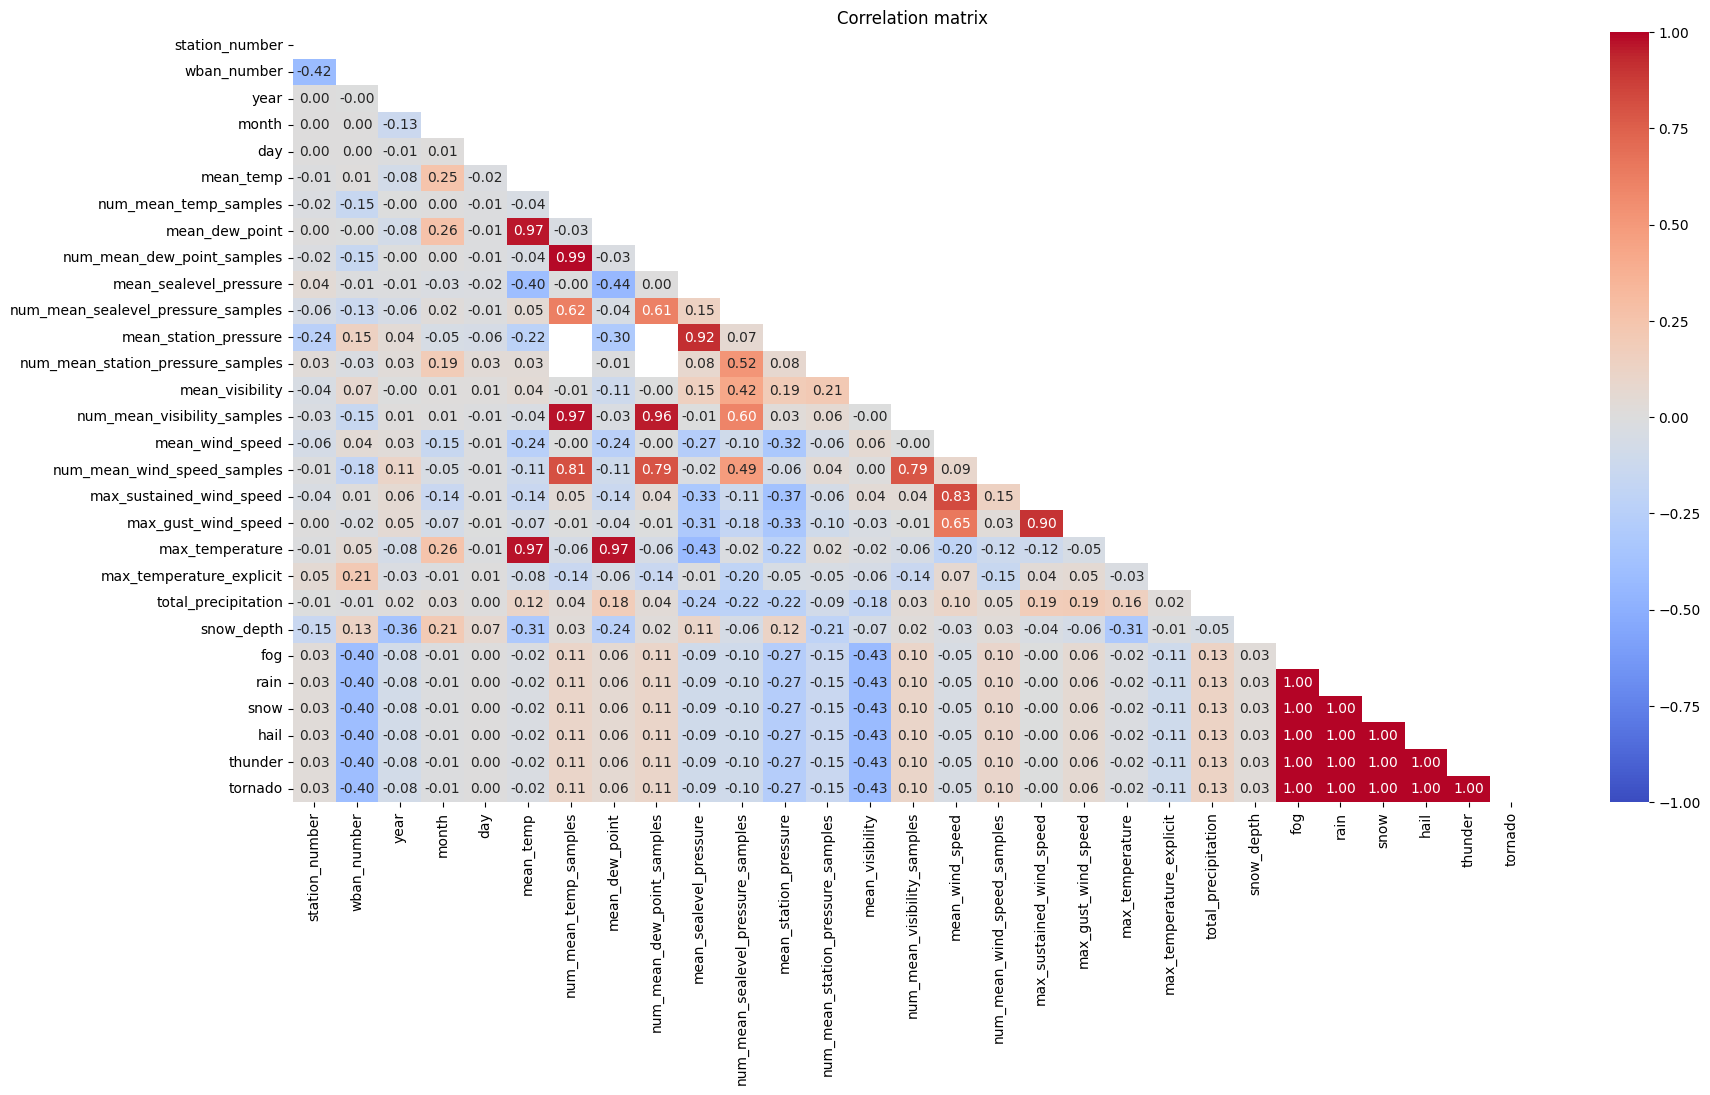

In [272]:
plotCorrelationMatrix(df_train)

It is very unlikely that we have a perfect correlation with all the binary variables, maybe our data is flawed or I did something wrong in the preprocessing.

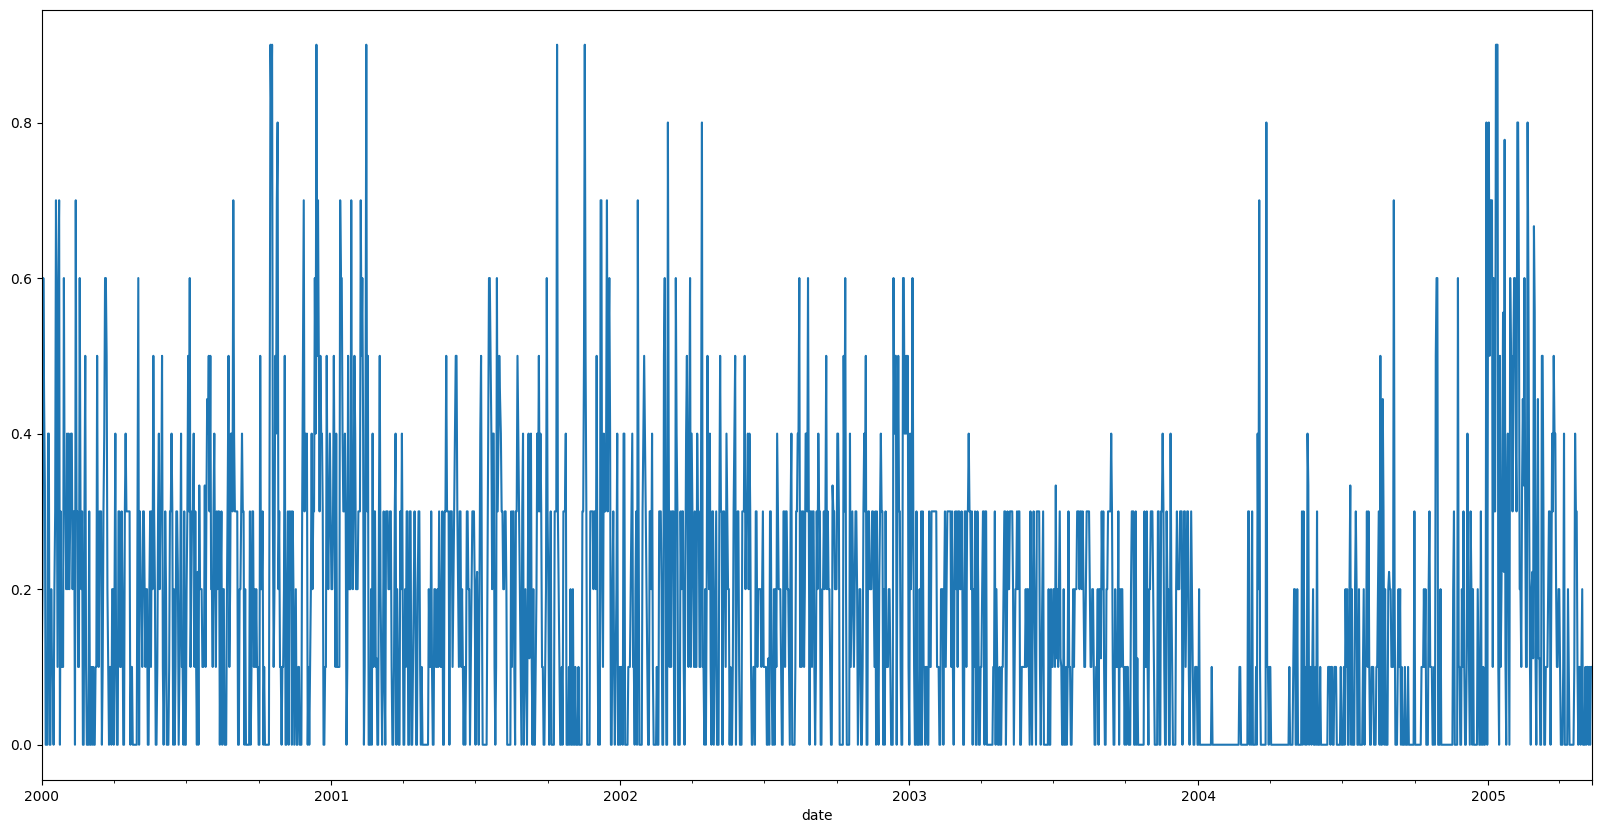

In [273]:
plotTimeSeries(df_train, "snow", resolution="D")

C:\Users\marc_\AppData\Local\Temp\ipykernel_13036\3100331414.py:21: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  plotData = df[column].resample(resolution).mean()


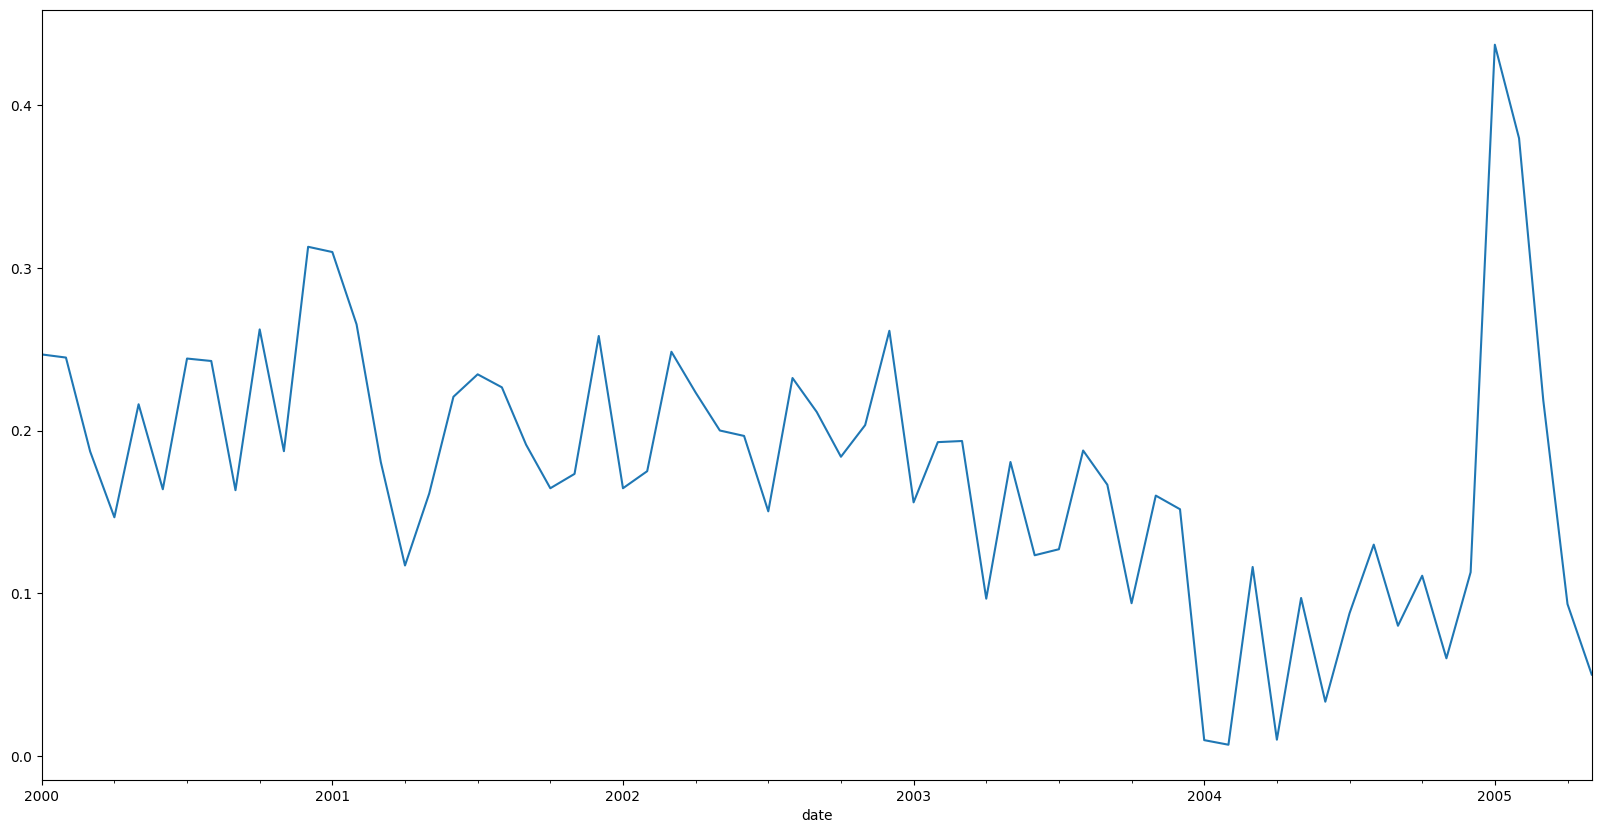

In [274]:
plotTimeSeries(df_train, "snow", resolution="M")

<Axes: xlabel='date,snow'>

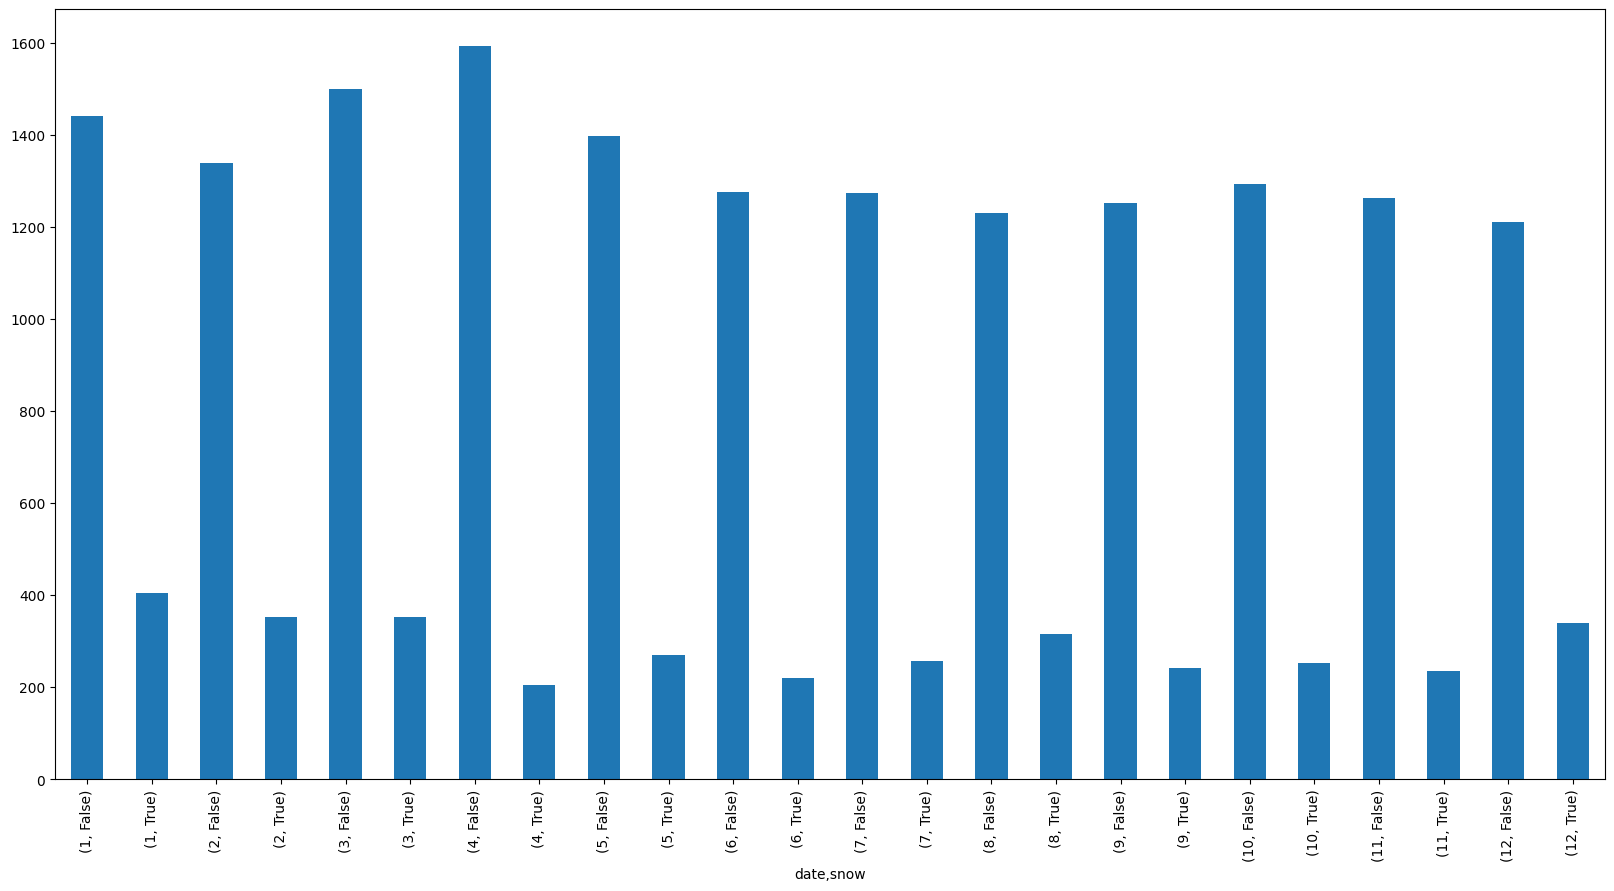

In [275]:
df_train.groupby(df_train.index.month)["snow"].value_counts().plot(kind="bar", figsize=(20, 10))

We see that in winter months the likelihood of snow is higher, but still a lot more days with no snow.

<Axes: xlabel='snow'>

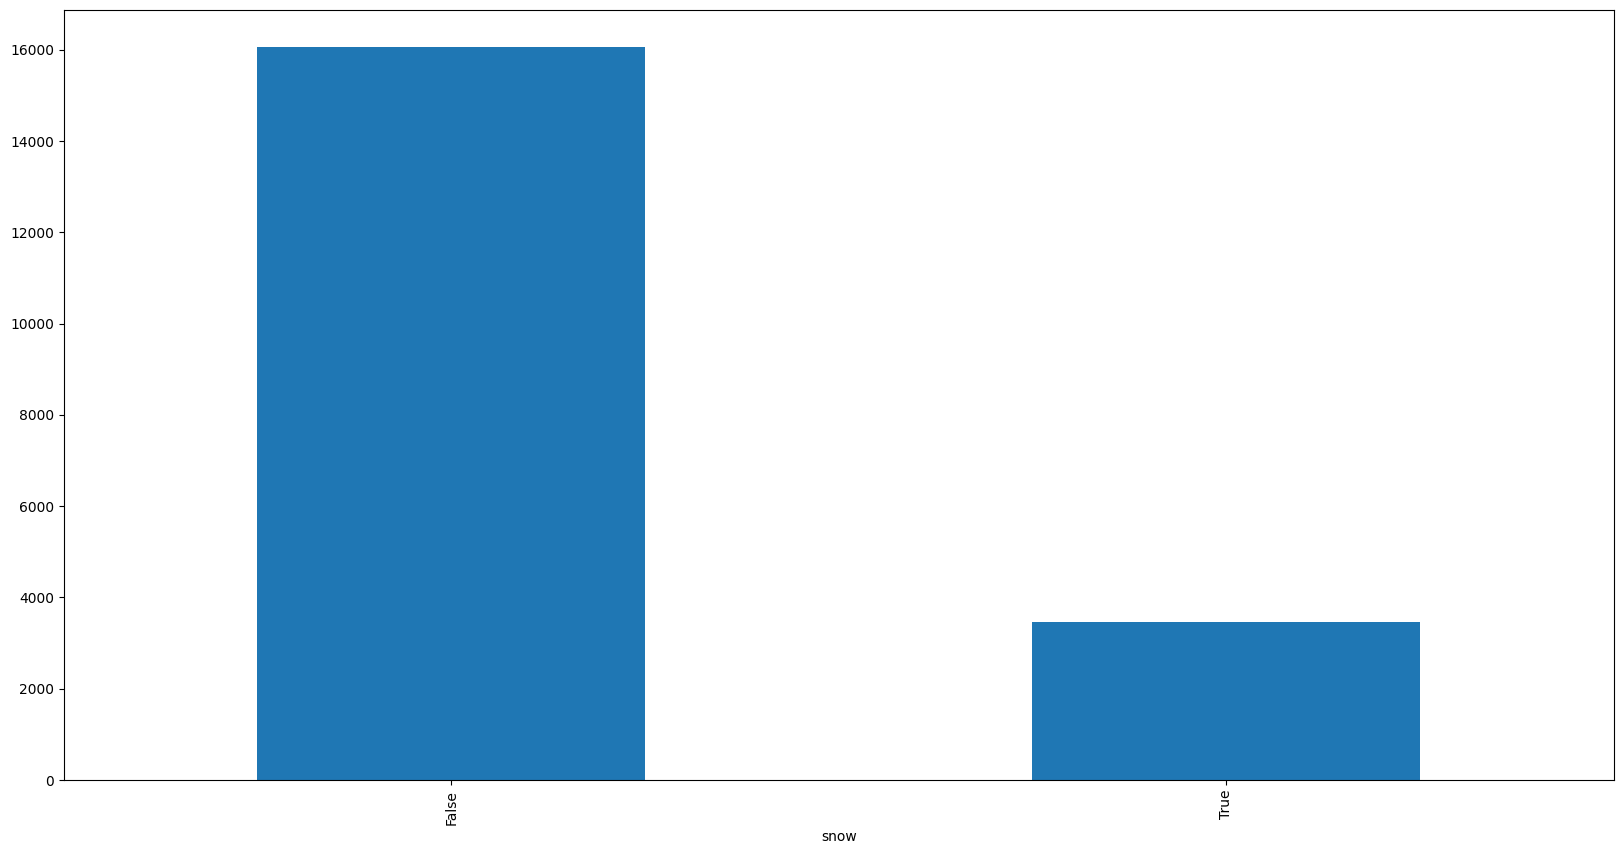

In [276]:
df_train["snow"].value_counts().plot(kind="bar", figsize=(20, 10))

In [277]:
# # Select only float64 columns
# float_cols = df_train.select_dtypes(include='float64').columns.tolist()

# # Include the snow flag (assumed bool or categorical)
# cols_for_pairplot = ['snow'] + float_cols

# # Subset your dataframe
# df_subset = df_train[cols_for_pairplot].reset_index(drop=True)

# # Plot pairplot with hue='snow'
# sns.pairplot(df_subset, hue='snow', diag_kind='kde', plot_kws={'alpha':0.6})

# plt.suptitle('Pairplot of Float Variables Grouped by Snow', y=1.02)
# plt.show()

Most of these are highly indicative of snow fall, will use them all

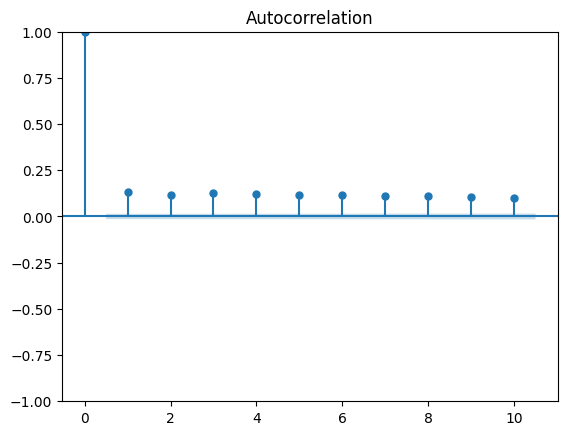

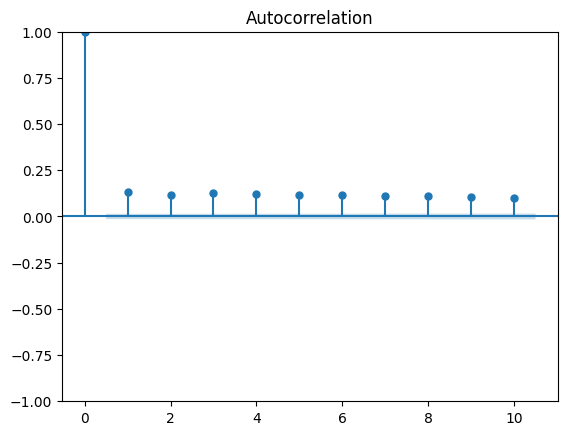

In [278]:
# Plot acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(df_train["snow"], lags=10)

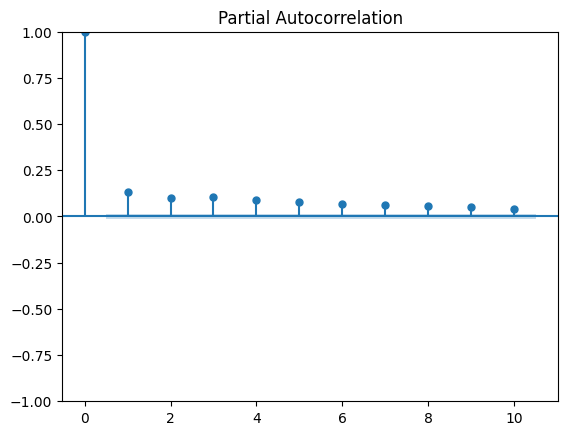

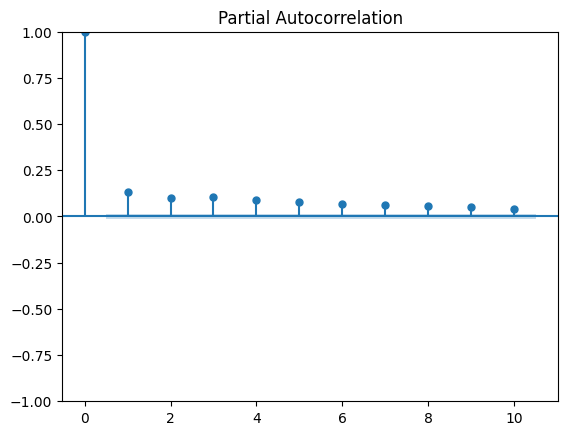

In [279]:
plot_pacf(df_train["snow"], lags=10)

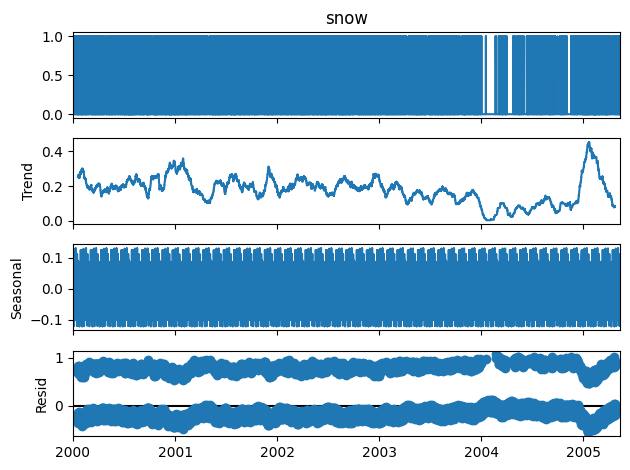

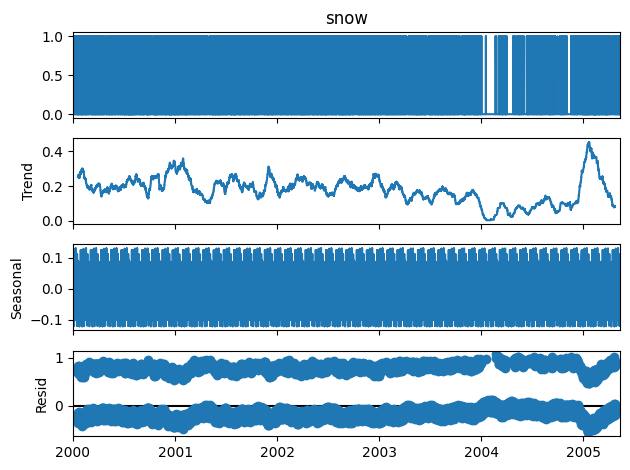

In [280]:
# seasonal_decompose
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df_train["snow"], model='additive', period=365)
result.plot()

In [281]:
df_train[['max_temperature_explicit','station_number', 'wban_number']].fillna("missing")

,max_temperature_explicit,station_number,wban_number
date,,,
2000-01-01,True,725326,99999
2000-01-01,False,725315,99999
2000-01-01,True,725316,99999
2000-01-01,False,725314,99999
2000-01-01,False,725320,14842
...,...,...,...
2005-05-12,True,725327,99999
2005-05-12,True,725330,14827
2005-05-12,False,725305,99999


In [282]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19524 entries, 2000-01-01 to 2005-05-12
Data columns (total 29 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   station_number                      19524 non-null  int64  
 1   wban_number                         19524 non-null  int64  
 2   year                                19524 non-null  int64  
 3   month                               19524 non-null  int64  
 4   day                                 19524 non-null  int64  
 5   mean_temp                           19524 non-null  float64
 6   num_mean_temp_samples               19524 non-null  int64  
 7   mean_dew_point                      19517 non-null  float64
 8   num_mean_dew_point_samples          19517 non-null  float64
 9   mean_sealevel_pressure              17175 non-null  float64
 10  num_mean_sealevel_pressure_samples  17175 non-null  float64
 11  mean_station_pressure   

In [283]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

# Feature Engineering
def createFeaturesDf(df: pd.DataFrame, oh_encoder=None, mean_imputer=None) -> pd.DataFrame:
    
    feature_list = [

        {"type": "temp", "periodName": "DateContinuous"},
        {"type": "temp", "periodName": "Month", "processingMethod": "sin"},
        {"type": "temp", "periodName": "Month", "processingMethod": "cos"},
        {"type": "lag", "column": "snow", "lag": 7},
        {"type": "rolling", "column": "snow", "windowSize": 7, "aggregation": 'sum'},
    ]
    df_features = createFeatures(df, feature_list).reset_index(drop=True)

    # One-hot encoding
    target_enc_cols = ['max_temperature_explicit','station_number', 'wban_number', 'fog', 'rain', 'hail', 'thunder', 'tornado'] # Year,  Month, Day will not make dummy variables
    df_cat = df.copy()[target_enc_cols].astype("string")
    df_cat = df_cat.fillna("missing")

    if oh_encoder:
        df_cat = oh_encoder.transform(df_cat)
    else:
        oh_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
        df_cat = oh_encoder.fit_transform(df_cat)
    
    df_cat = pd.DataFrame(df_cat, columns=oh_encoder.get_feature_names_out(target_enc_cols)).reset_index(drop=True)

    
    # Impute missing values Numerical
    df_num = df.copy().drop(columns=target_enc_cols+["snow"])
    if mean_imputer:
        df_num = mean_imputer.transform(df_num)
    else:
        mean_imputer = SimpleImputer(strategy="mean")
        df_num = mean_imputer.fit_transform(df_num)
    
    df_num = pd.DataFrame(df_num, columns=df.copy().drop(columns=target_enc_cols+["snow"]).columns).reset_index(drop=True)
    
    # Concatenate features
    X = pd.concat([df_features, df_cat, df_num], axis=1)
    drop_index = X.index[X.isna().any(axis=1)]
    
    # Reindex
    X.index = df.index
    drop_index = X.index[X.isna().any(axis=1)]

    y = df["snow"]

    y = y.drop(drop_index)
    X = X.drop(drop_index)
    
    return X, y, oh_encoder, mean_imputer

In [284]:
# Datasets
X_train, y_train, oh_encoder, mean_imputer = createFeaturesDf(df_train)
X_test, y_test, _, _ = createFeaturesDf(df_test, oh_encoder, mean_imputer)

In [285]:
# Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV


# Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

       False       1.00      1.00      1.00     15944
        True       1.00      1.00      1.00      1937

    accuracy                           1.00     17881
   macro avg       1.00      1.00      1.00     17881
weighted avg       1.00      1.00      1.00     17881

[[15944     0]
 [    0  1937]]


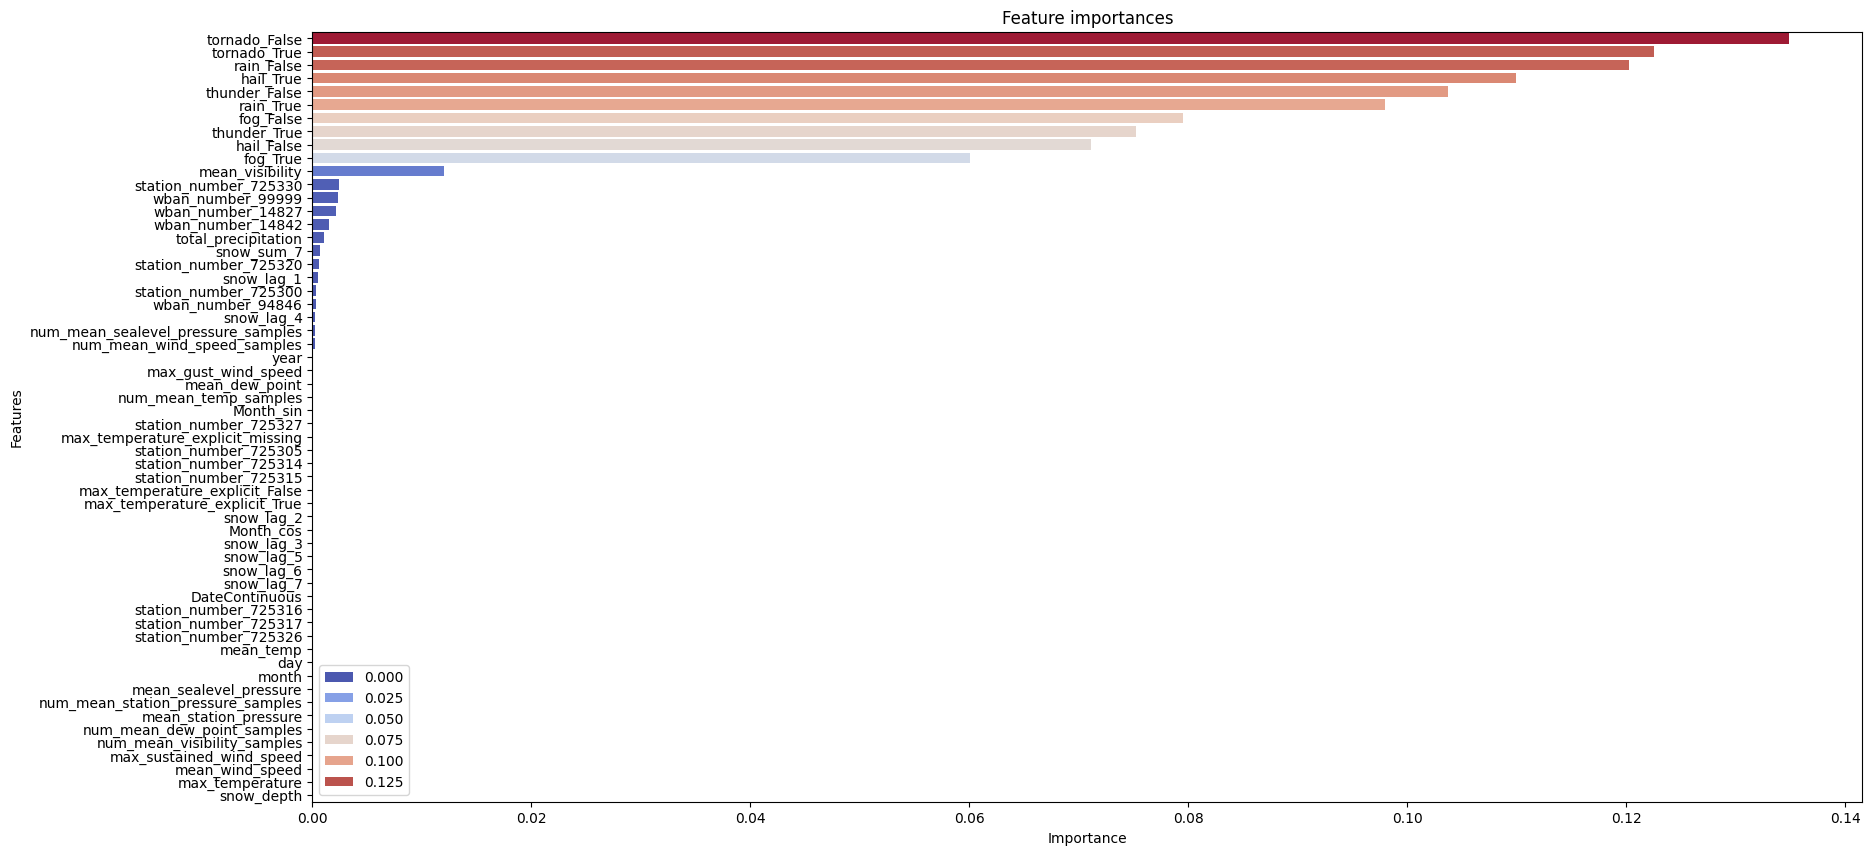

In [286]:
plotFeatureImportances(rf.feature_importances_, X_train.columns)

              precision    recall  f1-score   support

       False       1.00      1.00      1.00     15944
        True       1.00      1.00      1.00      1937

    accuracy                           1.00     17881
   macro avg       1.00      1.00      1.00     17881
weighted avg       1.00      1.00      1.00     17881

[[15944     0]
 [    0  1937]]


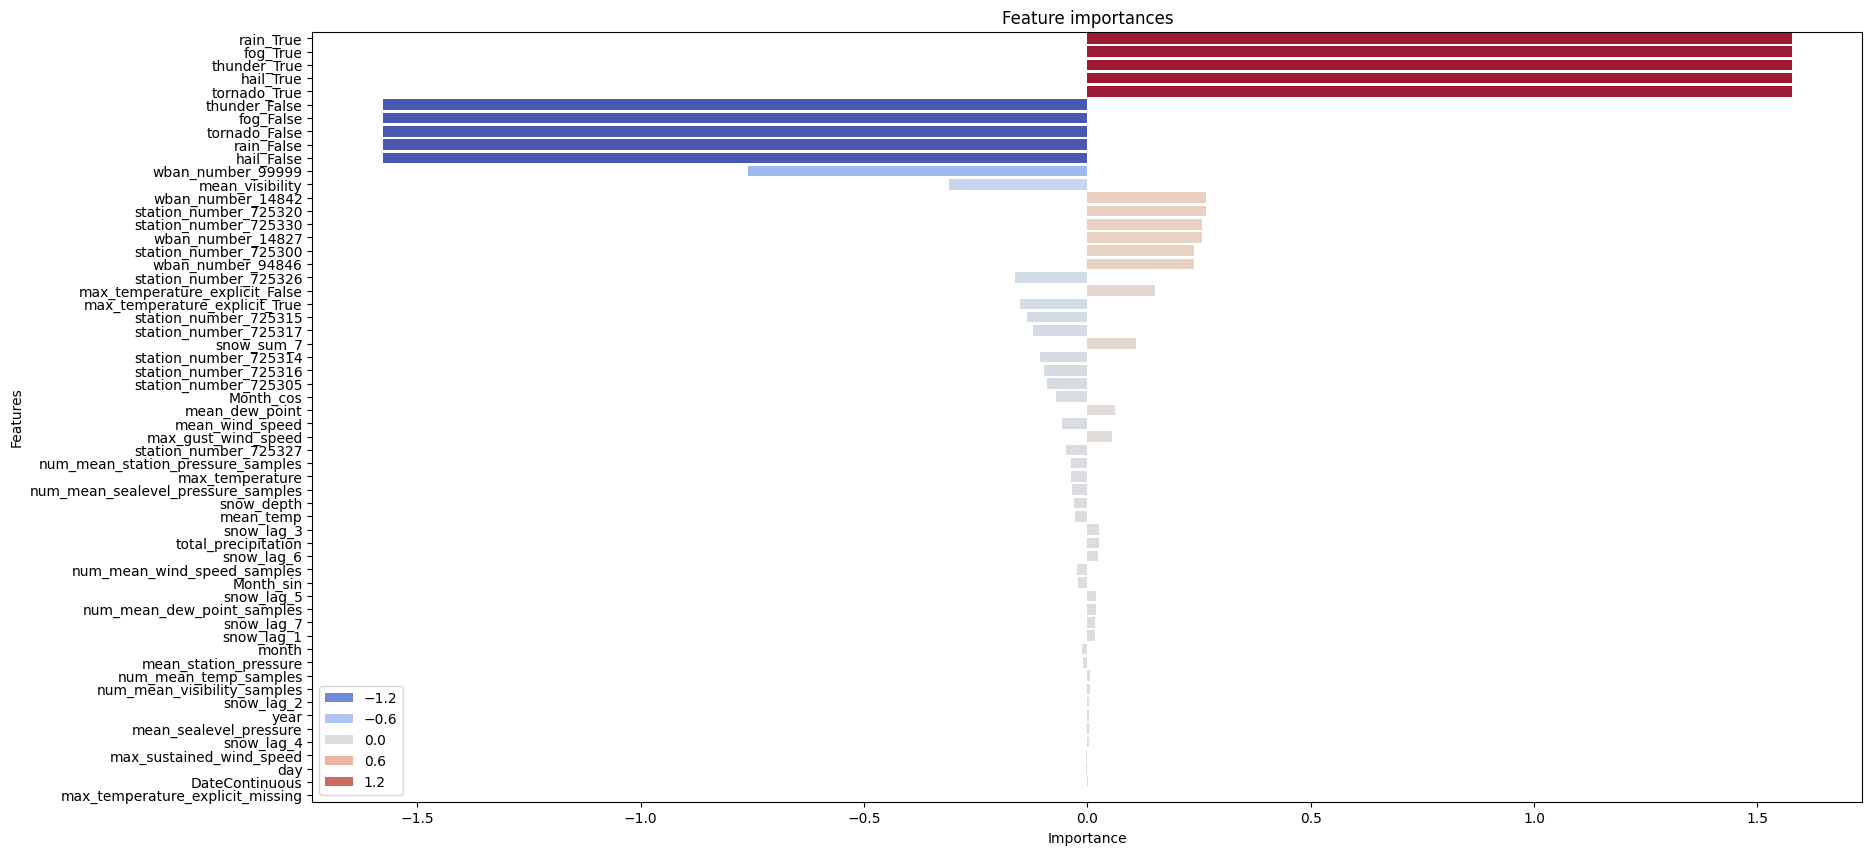

In [287]:
# Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

plotFeatureImportances(lr.coef_[0], X_train.columns)

The models are performing (too) well. If I had more time, I would investigate further I am very skeptical because they are performing so good. I saw that the binary predictors have a perfect correlation with snow, so naturally the prediction is perfect. Additional stuff to do would be crossvalidation and trying out other classifiers, pre-processing pipelines.

Notes:
- Not just accuracy but also precision and recall are perfect (skeptical)
- The binary predictors (tornado, hail, rain, etc) are highly predictive, in line with the high correlation.

In [296]:
# For index day 
y_pred[X_test.index == split_date] == y_test[X_test.index == split_date]

date
2005-05-20    True
2005-05-20    True
2005-05-20    True
2005-05-20    True
2005-05-20    True
2005-05-20    True
2005-05-20    True
2005-05-20    True
2005-05-20    True
2005-05-20    True
Name: snow, dtype: bool

So for our current day 20 years ago we predicted snow in every station. And that with a 100% accuracy.